# Proyecto EDA

**Autor:** Carlos Fort Duart

**Fecha:** 21/11/2025

**Archivo de datos analizado:** retail_store_sales.csv de la plataforma Kaggle

**Objetivo:** Exploratory Data Analysis (EDA) detallado.

**Información del dataset:** Se trata de un dataset sobre ventas minoristas, extraído de la plataforma Kaggle. Se trata de una fuente fiable pero sintética y con errores intencionados. Se presentan datos transaccionales individuales. Este dataset tiene valores faltantes en varias columnas, necesita estandarización de fechas, posibles incoherencias matemáticas y requiere imputación y limpieza, lo que lo hace perfecto para este proyecto de EDA.

## 1. Preparación y carga del dataset

### 1.1. Importamos librerías y leemos el fichero

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

# Ajustes de matplotlib para que los gráficos salgan de forma legible
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 10

### 1.2. Carga del dataset

In [ ]:
# Leemos el CSV
df = pd.read_csv("../data/retail_store_sales.csv")


## 2. Estructura del dataset

### 2.1. Dimensiones del dataset

In [ ]:
# Mostramos shape, primeras filas, info de tipos y conteo de nulos.
print("Shape (filas, columnas):", df.shape)

Shape (filas, columnas): (12575, 11)


Notemos que el dataset tiene 12575 filas, donde cada fila es información de una transacción individual; y 11 columnas, cada una para una variable diferente.

### 2.2. Variables

In [ ]:
# Mostramos las primeras 10 filas de la tabla
display(df.head(10))

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,NaN
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False
5,TXN_7482416,CUST_09,Patisserie,NaN,NaN,10.0,200.0,Credit Card,Online,2023-11-30,NaN
6,TXN_3652209,CUST_07,Food,Item_1_FOOD,5.0,8.0,40.0,Credit Card,In-store,2023-06-10,True
7,TXN_1372952,CUST_21,Furniture,NaN,33.5,NaN,NaN,Digital Wallet,In-store,2024-04-02,True
8,TXN_9728486,CUST_23,Furniture,Item_16_FUR,27.5,1.0,27.5,Credit Card,In-store,2023-04-26,False
9,TXN_2722661,CUST_25,Butchers,Item_22_BUT,36.5,3.0,109.5,Cash,Online,2024-03-14,False


A primera vista tenemos las siguientes variables:

**Transaction ID:** Identificador único de cada transacción. No es variable analítica, sino clave.

**Customer ID:** Identificador de cliente. Puede servir para análisis de recurrencia, CLV, etc.

**Category:** Categoría del producto (variable categórica). Importante para análisis de mix de ventas.

**Item:** Nombre del artículo. Puede tener alta cardinalidad.

**Price Per Unit:** Precio unitario. Variable numérica directa.

**Quantity:** Cantidad comprada. Numérica, puede relacionarse con volumen de compra.

**Total Spent:** Importe total de la compra. Debe relacionarse con Price Per Unit × Quantity.

**Payment Method:** Método de pago (categórica). Útil para análisis de cliente, tasas de adopción, etc.

**Location:** Ubicación de la tienda/venta. Variable categórica geográfica.

**Transaction Date:** Fecha de la transacción. Debería convertirse a datetime.

**Discount Applied:** Indica si se aplicó descuento. Puede ser categórica tipo “Yes/No”, numérica o incluso texto inconsistente.

### 2.3. Información de las variables. Tipos

In [ ]:
# Mostramos la información más relevante
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    12575 non-null  object 
 1   Customer ID       12575 non-null  object 
 2   Category          12575 non-null  object 
 3   Item              11362 non-null  object 
 4   Price Per Unit    11966 non-null  float64
 5   Quantity          11971 non-null  float64
 6   Total Spent       11971 non-null  float64
 7   Payment Method    12575 non-null  object 
 8   Location          12575 non-null  object 
 9   Transaction Date  12575 non-null  object 
 10  Discount Applied  8376 non-null   object 
dtypes: float64(3), object(8)
memory usage: 1.1+ MB


A continuación comentamos la estructura general del dataset a partir de la salida anterior. Cada fila representa una transacción individual.

Las columnas incluyen:

- Identificadores (como **Transaction ID** y **Customer ID**)

- Información descriptiva del producto (como **Category** y **Item**)

- Variables económicas (como **Price Per Unit**, **Quantity** y **Total Spent**)

- Información contextual (como **Payment Method** y **Location**)

- Fecha (como **Transaction Date**)

- Campo opcional de descuento (como **Discount Applied**)

Vemos que los tipos detectados son:

- 8 columnas tipo object (texto/categóricas)
- 3 columnas numéricas (float64)

A primera vista podemos decir que la columna de fecha aún está como texto (object), por lo que será necesario convertirla a datetime.

## 3. Evaluación de la calidad

### 3.1. Dominio y contexto de los datos

Como comentábamos en el inicio, se trata de datos sobre transacciones individuales de ventas de minoristas.

### 3.2. Resumen de las variables cuantitativas

In [ ]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Resumen numércio
numeric_summary = numeric_cols.describe().T
numeric_summary["range"] = numeric_summary["max"] - numeric_summary["min"]
numeric_summary

,count,mean,std,min,25%,50%,75%,max,range
Price Per Unit,11966.0,23.365912,10.743519,5.0,14.0,23.0,33.5,41.0,36.0
Quantity,11971.0,5.536380,2.857883,1.0,3.0,6.0,8.0,10.0,9.0
Total Spent,11971.0,129.652577,94.750697,5.0,51.0,108.5,192.0,410.0,405.0


Además de los estadísticos media, desviación y cuartiles, encontramos el mínimo y el máximo.
- La variable **PricePerUnit** toma valores entre 5 y 41.
- La variable **Quantity** toma valores entre 1 y 10
- La variable **Total Spent** toma valores entre 5 y 410.

### 3.3. Información de las variables categóricas

In [ ]:
# Esto ayuda a detectar IDs, categorías con errores tipográficos, o columnas que no aportan.

# Número de valores únicos por columna (cardinalidad)
unique_counts = pd.DataFrame(df.nunique(dropna=False), columns=['n_unique']).sort_values('n_unique', ascending=False)
display(unique_counts.head(40))

# Mostrar top values de columnas no numéricas
non_num_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in non_num_cols[:10]:
    print(f"\nColumna: {col}  —  Unique: {df[col].nunique(dropna=False)}  —  Nulos: {df[col].isnull().sum()}")
    print(df[col].value_counts(dropna=False).head(20).to_string())


,n_unique
Transaction ID,12575
Transaction Date,1114
Total Spent,228
Item,201
Price Per Unit,26
Customer ID,25
Quantity,11
Category,8
Payment Method,3
Discount Applied,3



Columna: Transaction ID  —  Unique: 12575  —  Nulos: 0
Transaction ID
TXN_2407494    1
TXN_6867343    1
TXN_3731986    1
TXN_9303719    1
TXN_9458126    1
TXN_4575373    1
TXN_7482416    1
TXN_3652209    1
TXN_1372952    1
TXN_9728486    1
TXN_2722661    1
TXN_8776416    1
TXN_5422631    1
TXN_5874772    1
TXN_4413070    1
TXN_6295698    1
TXN_7239201    1
TXN_4397672    1
TXN_9743446    1
TXN_1434202    1

Columna: Customer ID  —  Unique: 25  —  Nulos: 0
Customer ID
CUST_05    544
CUST_24    543
CUST_13    534
CUST_08    533
CUST_09    519
CUST_15    519
CUST_16    515
CUST_23    513
CUST_20    507
CUST_18    507
CUST_01    507
CUST_11    503
CUST_10    501
CUST_22    501
CUST_21    498
CUST_12    498
CUST_07    491
CUST_02    488
CUST_17    487
CUST_19    487

Columna: Category  —  Unique: 8  —  Nulos: 0
Category
Electric household essentials         1591
Furniture                             1591
Food                                  1588
Milk Products                         1584


Comentamos brevemente las salidas.

- La variable **Transaction ID** tiene 12.575 valores únicos y 0 nulos, es decir, cada transacción tiene un ID único. Esto confirma que no existen duplicados y que la columna sirve como clave primaria perfecta.

- La variable **Customer ID** tiene 25 valores únicos y 0 nulos. Hay 12.575 transacciones realizadas por solo 25 clientes, lo que significa que en promedio cada cliente realiza 503 compras aproximadamente. Algunos clientes compran más que otros, ya que el cliente más activo (CUST_05) tiene 544 transacciones y el cliente menos activo (entre los mostrados) tiene entre 487–491.

- La variable **Category** tiene 8 valores únicos y 0 nulos. Las categorías son "Electric household essentials", "Furniture", "Food", "Milk Products",  "Butchers", "Beverages", "Computers and electric accessories" y "Patisserie". Observamos que las categorías están muy equilibradas ya que todas rondan entre 1528 y 1591 registros, lo cual indica que el dataset está bien balanceado entre tipos de productos y no hay una categoría claramente dominante. Las ventas parecen distribuidas de forma bastante homogénea.

- La variable **Item** tiene 201 valores únicos y 1213 nulos. Es la variable con mayor diversidad de productos, lo cual es normal en retail. Sin embargo, 1213 transacciones no registran item, solo categoría. Las posibles causas pueden ser: errores en el sistema de captura, artículos descatalogados, transacciones donde solo se registró categoría, ...

- La variable **Payment Method** tiene 3 valores únicos y 0 nulos. Se distribuyen en 4310 en la categoría "Cash", 4144 en la categoría "Digital Wallet" y 4121 en la categoría "Credit Card". Los tres métodos están muy equilibrados pero el efectivo sigue siendo ligeramente dominante.

- La variable **Location** tiene 2 valores únicos y 0 nulos. En concreto, la categoría "Online" con	6.354 y la "In-store" con	6.221. Ventas casi 50%–50% entre online y físico.

- La variable **Transaction Date** tiene 1114 valores únicos y 0 nulos. Notemos que todas las transacciones tienen fecha, lo que es muy útil para análisis temporal.Pero antes debe convertirse a tipo datetime.

- La variable **Discount Applied** tiene 3 valores únicos (True, False, NaN) y 4199 nulos: True	4219, NaN	4199 y False	415. El 33% de los datos no indican si hubo descuento. Lo más probable es que los nulos signifiquen que o bien no se aplicó descuento y no se registró, bien el campo se introdujo en una fecha posterior o bien hay una falta de consistencia en el sistema. Notemos que muchísimas más operaciones tienen True que False. Esto sugiere que cuando hay descuento, sí se registra y que cuando no lo hay, puede ser que muchas veces se dejó vacío.

### 3.4. Detección valores nulos


In [ ]:
# Conteo de nulos absoluto y porcentual
missing = pd.DataFrame(df.isnull().sum(), columns=['missing_count'])
missing['missing_pct'] = (missing['missing_count'] / len(df)) * 100
display(missing.sort_values('missing_pct', ascending=False).head(30))


,missing_count,missing_pct
Discount Applied,4199,33.391650
Item,1213,9.646123
Price Per Unit,609,4.842942
Total Spent,604,4.803181
Quantity,604,4.803181
Transaction ID,0,0.000000
Customer ID,0,0.000000
Category,0,0.000000
Payment Method,0,0.000000
Location,0,0.000000


Observamos que las variables **Transaction ID**, **Customer ID**, **Category**, **Payment Method**, **Location** y **Transaction Date** están completas y no tienen valores faltantes.

En cambio, las variables restantes sí que tienen valores nulos. Observamos que las variables **Total Spent** y **Quantity** tienen 604 valores faltantes, es decir, un 4,8% de las filas tienen estas columnas vacías. De forma similar, **Price Per Unit**, **Item** y **Discount Applied** tienen 609, 1213 y 4199 valores faltantes, respectivamente.


### 3.5. Detección filas duplicadas

In [ ]:
# Contamos duplicados exactos y mostramos algunos ejemplos (si existen)
dup_count = df.duplicated().sum()
print("Filas duplicadas exactas:", dup_count)
if dup_count > 0:
    display(df[df.duplicated(keep=False)].head(20))



Filas duplicadas exactas: 0


Observamos que no hay filas duplicadas.

### 3.6. Búsquedas de posibles incoherencias


Comprobamos que el total gastado es el precio por unidad por cantidad.

In [ ]:
df['Calculated Total'] = df['Price Per Unit'] * df['Quantity']

inconsistencias = df[
    abs(df['Total Spent'] - df['Calculated Total']) > 0.001
]

print(f"Inconsistencias Total Spent detectadas: {len(inconsistencias)}")

Inconsistencias Total Spent detectadas: 0


No hay inconsistencias matemáticas encontradas, es decir, el total está bien calculado como el producto del precio por unidad y la cantidad.

Comprobamos también que no haya ningún valor de Precio Por Unidad o Cantidad que sea negativo, ya que no tendrían sentido estos valores. Deben ser positivos.

In [ ]:
negativos = df[
    (df['Price Per Unit'] < 0) | (df['Quantity'] < 0)
]

print("Filas con valores negativos:")
print(len(negativos))

Filas con valores negativos:
0


No hay valores negativos.

### 3.7. Outliers

In [ ]:
numeric_cols = ['Price Per Unit', 'Quantity', 'Total Spent']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers detectados")


Price Per Unit: 0 outliers detectados
Quantity: 0 outliers detectados
Total Spent: 60 outliers detectados


Sobre la variable **Price Per Unit** no hay outliers. Esto indica que los precios por unidad están dentro de un rango razonable: no hay precios anormalmente altos, no hay precios sospechosamente bajos y la distribución de precios es homogénea y estable.

La variable **Quantity** tampoco presenta valores extremos. Esto significa que los valores de Quantity se concentran en un rango estrecho. El comportamiento de compra es uniforme entre productos y no hay compras extrañamente grandes.

**Total Spent** depende de dos variables. Aunque cada una individualmente no tenga outliers, la combinación de un precio alto y una cantidad alta puede producir valores extremos. Esto sí que tiene sentido lógico.

# -------------------------------

## 4. Limpieza

### 4.1. Corregir tipos de datos

Convertimos a datetime la variable **Transaction Date** ya que hasta ahora venía dada como tipo objeto.

In [ ]:
# Conversión a datetime
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")
#Comprobamos el cambio de tipo
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    12575 non-null  object        
 1   Customer ID       12575 non-null  object        
 2   Category          12575 non-null  object        
 3   Item              11362 non-null  object        
 4   Price Per Unit    11966 non-null  float64       
 5   Quantity          11971 non-null  float64       
 6   Total Spent       11971 non-null  float64       
 7   Payment Method    12575 non-null  object        
 8   Location          12575 non-null  object        
 9   Transaction Date  12575 non-null  datetime64[ns]
 10  Discount Applied  8376 non-null   object        
 11  Calculated Total  11362 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 1.2+ MB


### 4.2. Imputación de valores faltantes de las variable Item

En el dataset original, la columna **Item** contiene valores faltantes. Al analizar la estructura de los datos, observamos que cada valor de **Item** sigue un patrón común:

Item_<número>_<prefijo_de_categoria_en_mayúsculas>


Por ejemplo:

- Item_12_FOOD

- Item_27_MILK

Esto indica que la variable **Item** no es un nombre de producto, sino un identificador compuesto. El identificador combina un número aleatorio asociado al ítem y un prefijo en mayúsculas que procede de la categoría a la que pertenece.

Por lo tanto, para rellenar los valores faltantes de **Item**, se mantiene la lógica del dataset original, generando un nuevo identificador cumpliendo el mismo estándar.

In [ ]:
# Crear copia del dataframe original
clean_df = df.copy()

import random

# Diccionario de sufijos para cada categoría
suffix_map = {
    "Food": "FOOD",
    "Patisserie": "PAT",
    "Milk Products": "MILK",
    "Butchers": "BUT",
    "Beverages": "BEV",
    "Furniture": "FUR",
    "Computers and electric accessories": "CEA",
    "Electric household essentials": "EHE"
}

# Seleccionar los índices donde Item es NaN
missing_items = clean_df[clean_df["Item"].isna()].index

# Rellenar los valores faltantes en la copia
for idx in missing_items:
    category = clean_df.at[idx, "Category"]
    suffix = suffix_map.get(category, "UNK")  # Si aparece categoría nueva
    random_number = random.randint(1, 30)
    clean_df.at[idx, "Item"] = f"Item_{random_number}_{suffix}"

# Comprobamos que ya no hay nulos en la columna Item
null_count = clean_df["Item"].isna().sum()
print(f"Número de valores nulos en Item: {null_count}")


Número de valores nulos en Item: 0


Para ver si lo ha hecho bien, identificamos qué filas tenían Item nulo en el dataframe original (df) y mostramos esas mismas filas en clean_df para comprobar que ahora están imputadas.

In [ ]:
# Filas donde Item era nulo en el dataframe original
original_null_rows = df[df["Item"].isna()].index

# Mostrar esas filas en el dataframe limpio
print("Filas con Item nulo en df y su estado en clean_df:")
clean_df.loc[original_null_rows, ["Category", "Item"]].head(10)

Filas con Item nulo en df y su estado en clean_df:


,Category,Item
5,Patisserie,Item_9_PAT
7,Furniture,Item_11_FUR
11,Milk Products,Item_11_MILK
15,Beverages,Item_5_BEV
17,Milk Products,Item_30_MILK
19,Furniture,Item_22_FUR
21,Milk Products,Item_24_MILK
25,Furniture,Item_18_FUR
32,Food,Item_5_FOOD
34,Patisserie,Item_10_PAT


### 4.3. Imputación de valores faltantes de las variables Price Per Unit, Quantity y Total Spent

La columna **Price Per Unit** es fundamental para la coherencia del dataset, pues forma parte directa de la relación:

Total Spent=Price Per Unit×Quantity

Por lo tanto, vamos a aplicar una imputación jerárquica y lógica.

En primer lugar, haremos una reconstrucción matemática cuando es posible.
Si Total Spent y Quantity existen, se calcula:

Price Per Unit=Total Spent/Quantity

Este es el método más fiable porque no introduce sesgo externo y respeta la naturaleza real del dato.

Cunado no es posible reconstruir, imputaremos la media agrupada por Item.
Si también faltan los valores anteriores, se usa la media del mismo producto (Item) para mantener consistencia ya que productos idénticos suelen tener precios comparables.

Como tercera alternativa, valor por defecto = 50 cuando no hay alternativa.
Si aún no existe forma de imputar, se asigna un valor constante neutral para evitar dejar nulos en la base. Este último paso afecta a muy pocos registros y sirve como último recurso.


In [ ]:
# Primera Opción: fórmula
clean_df['Price Per Unit'] = (
    clean_df['Price Per Unit']
    .fillna(
        (clean_df['Total Spent'] / clean_df['Quantity'])
        .where(clean_df['Quantity'] != 0)
    )
)
# Segunda Opción: Media agrupada por item
clean_df['Price Per Unit'] = (
    clean_df['Price Per Unit']
    .fillna(clean_df.groupby('Item')['Price Per Unit'].transform('mean'))
)

# Tercera Opción: imputación valor 50
clean_df['Price Per Unit'] = clean_df['Price Per Unit'].fillna(50.0)

En cuanto a la imputación en **Quantity**, vamos a aplicar el mismo razonamiento que en la columna anterior, pues las tres variables están relacionadas mediante la misma fórmula:

Quantity=Total Spent/Price Per Unit

Como segunda opción, imputaremos la media por artículo (Item) si no es posible.

Como última opción, imputaremos un valor por defecto = 5 unidades si aún falta valor.

Este enfoque mantiene la coherencia matemática del dataset, la similaridad entre productos del mismo tipo y la eliminación definitiva de nulos



In [ ]:
# Primera Opción: Fórmula
clean_df['Quantity'] = (
    clean_df['Quantity']
    .fillna(
        (clean_df['Total Spent'] / clean_df['Price Per Unit'])
        .where(clean_df['Price Per Unit'] != 0)
    )
)

# Segunda Opción: Media agrupada por item
clean_df['Quantity'] = (
    clean_df['Quantity']
    .fillna(clean_df.groupby('Item')['Quantity'].transform('mean'))
)

# Tercera Opción: imputación valor 5
clean_df['Quantity'] = clean_df['Quantity'].fillna(5.0)


Por último, en cuanto a la imputación en **Total Spent**, una vez las columnas Price Per Unit y Quantity ya están completas, imputar los nulos restantes es trivial.

Total Spent=Price Per Unit×Quantity

Este método recupera el dato exacto con la menor incertidumbre posible.

In [ ]:
clean_df['Total Spent'] = (
    clean_df['Total Spent']
    .fillna(clean_df['Price Per Unit'] * clean_df['Quantity'])
)

Comprobamos ahora los valores nulos

In [ ]:
# REVISAR NULOS
print("Valores nulos restantes en cada columna:")
print(clean_df.isna().sum())

Valores nulos restantes en cada columna:
Transaction ID         0
Customer ID            0
Category               0
Item                   0
Price Per Unit         0
Quantity               0
Total Spent            0
Payment Method         0
Location               0
Transaction Date       0
Discount Applied    4199
Calculated Total    1213
dtype: int64


### 4.4. Imputación de valores de la variable Discount Applied

La columna **Discount Applied** solo puede tomar tres valores (True, False, NaN). Al analizar la distribución observamos que la mayoría de valores no aplican descuento. Los valores nulos no indican explícitamente lo contrario.

Por lo tanto, decidimos imputar los faltantes como False, siendo la decisión más conservadora y coherente con el comportamiento mayoritario de la base.

In [ ]:

clean_df['Discount Applied'] = clean_df['Discount Applied'].fillna('False')


Eliminamos la columna Calculated Total creada para los cálculos.

In [ ]:
# Eliminar la columna Calculated Total creada
if "Calculated Total" in clean_df.columns:
    clean_df = clean_df.drop(columns=["Calculated Total"])

# Comprobar resultado
clean_df.head()

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,False
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False


Por último, revisamos si quedan valores nulos

In [ ]:

print("Valores nulos restantes en cada columna:")
print(clean_df.isna().sum())

Valores nulos restantes en cada columna:
Transaction ID      0
Customer ID         0
Category            0
Item                0
Price Per Unit      0
Quantity            0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
Discount Applied    0
dtype: int64


### 4.5. Estandarización del nombre de las columnas

Estandarizamos el nombre de las columnas antes de guardar el dataframe limpio, para que estén escritos en minúsculas y separadas las palabras por guión bajo (snake_case).

In [ ]:
# Estandarizar nombres de columnas correctamente
clean_df.columns = (
    clean_df.columns
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
)

print(clean_df.columns)

Index(['transaction_id', 'customer_id', 'category', 'item', 'price_per_unit',
       'quantity', 'total_spent', 'payment_method', 'location',
       'transaction_date', 'discount_applied'],
      dtype='object')


### 4.6. Guardar CSV limpio

Una vez el dataframe limpio, lo guardamos.

In [ ]:
# Guardar el dataframe limpio como CSV
clean_df.to_csv("../data/retail_store_sales_clean.csv", index=False)


## 5. Matriz de correlaciones

Obtenemos la matriz de correlaciones solo con las variables numéricas del clean_df.

In [ ]:
# Seleccionar únicamente columnas numéricas
numeric_cols = clean_df.select_dtypes(include=['int64', 'float64'])

# Matriz de correlaciones
corr_matrix = numeric_cols.corr()

# Mostrar matriz
print(corr_matrix)

                price_per_unit  quantity  total_spent
price_per_unit        1.000000  0.009467     0.639360
quantity              0.009467  1.000000     0.705015
total_spent           0.639360  0.705015     1.000000


La visualizamos en un mapa de calor.

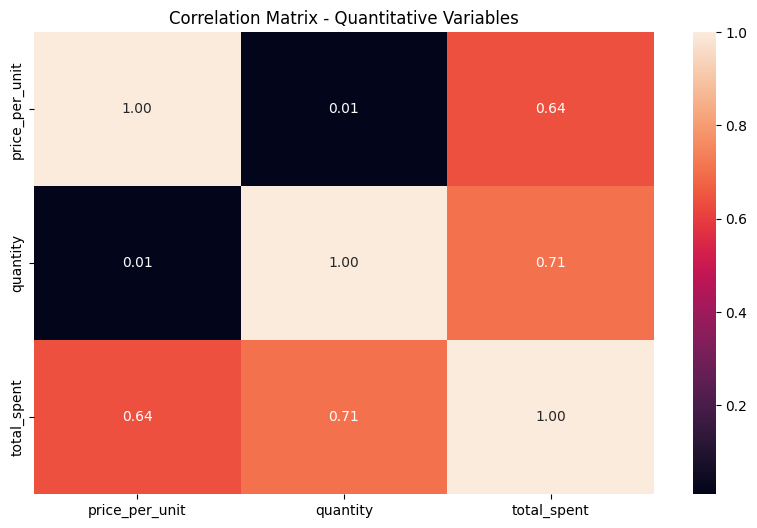

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix - Quantitative Variables")
plt.show()

Se comparan las relaciones entre price_per_unit (precio unitario), quantity (cantidad) y total_spent (total gastado).

Quantity y Total Spent tienen una correlación fuerte (≈ 0.71), lo cual es lógico: a mayor cantidad comprada, mayor gasto total. El precio unitario también está correlacionado con el gasto total (≈ 0.64), ya que compras de productos más caros elevan el valor de la transacción.

La relación entre precio y cantidad es casi nula, lo que significa que los clientes no tienden a comprar más o menos unidades en función del precio.

## 6. Visualizaciones gráficas

### 6.1. Distribuciones de algunas variables

A continuación mostramos las distribuciones de la variables cuantitativas (histograma), con una curva KDE encima.

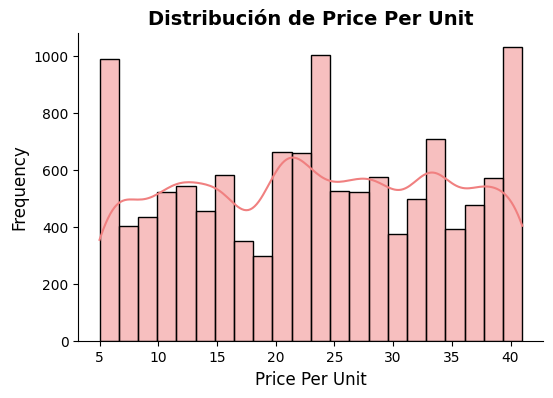

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=clean_df,
    x="price_per_unit",
    kde=True,
    color="lightcoral"
)

plt.title("Distribución de Price Per Unit", fontsize=14, fontweight="bold")
plt.xlabel("Price Per Unit", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

La distribución del precio por unidad muestra una tendencia relativamente uniforme, sin grandes concentraciones claras en un rango concreto. Esto indica que los precios de los productos en el conjunto de datos están bastante dispersos, ofreciendo una gama variada de precios disponible para los clientes.
No se observan valores extremos muy alejados del resto, lo cual sugiere que no existen outliers significativos en esta variable.

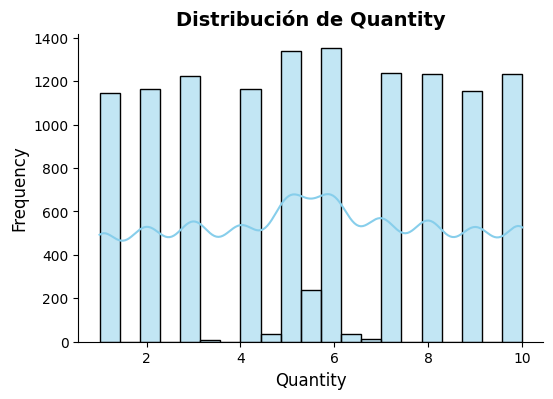

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=clean_df,
    x="quantity",
    kde=True,
    color="skyblue"
)

plt.title("Distribución de Quantity", fontsize=14, fontweight="bold")
plt.xlabel("Quantity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

La cantidad comprada por transacción presenta una distribución con valores bastante homogéneos, sin picos pronunciados, lo que indica que los clientes suelen comprar cantidades variadas con una frecuencia similar.
Esto puede interpretarse como que no existe un patrón dominante de compra (por ejemplo, siempre comprar 1 unidad), sino que el comportamiento de compra es bastante diverso y repartido.

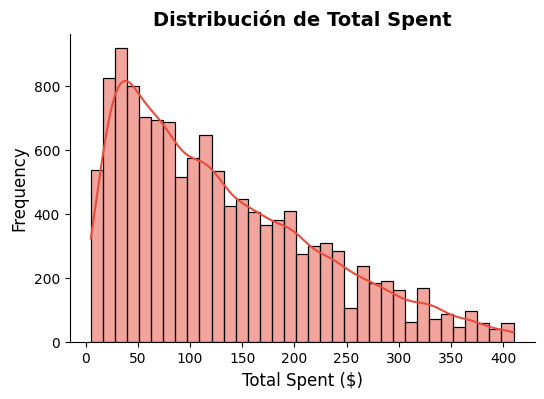

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=clean_df,
    x="total_spent",
    kde=True,
    color="#e74c3c"
)

plt.title("Distribución de Total Spent", fontsize=14, fontweight="bold")
plt.xlabel("Total Spent ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

La distribución del total gastado muestra una forma claramente sesgada a la derecha, lo que es habitual en datos económicos. La mayoría de los clientes realiza compras con importes relativamente bajos, mientras que las compras de gasto elevado son menos frecuentes, pero sí existen algunos casos de desembolsos altos.
Esto sugiere que esta variable presenta valores extremos y mayor variabilidad, comparada con Price Per Unit y Quantity, lo que es lógico ya que depende de ambas variables acumuladas.

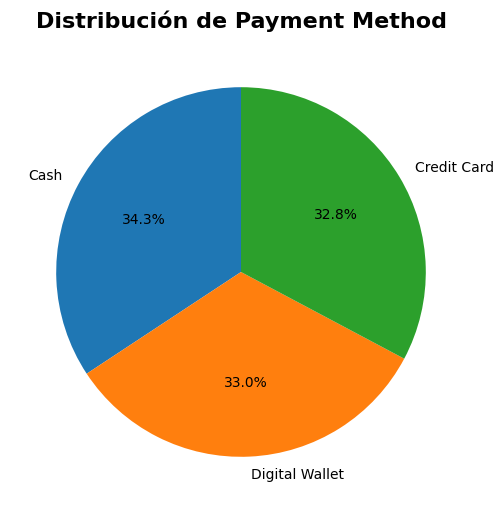

In [ ]:
import matplotlib.pyplot as plt

# Conteo por método de pago
payment_method = clean_df["payment_method"].value_counts()

# Gráfico de tarta
plt.figure(figsize=(6,6))
plt.pie(
    payment_method.values,
    labels=payment_method.index,
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Distribución de Payment Method", fontsize=16, fontweight="bold", pad=10)
plt.show()

Observamos que no hay apenas diferencias entre las diferentes formas de pago.

### 6.2. Visualizaciones de dos o tres variables

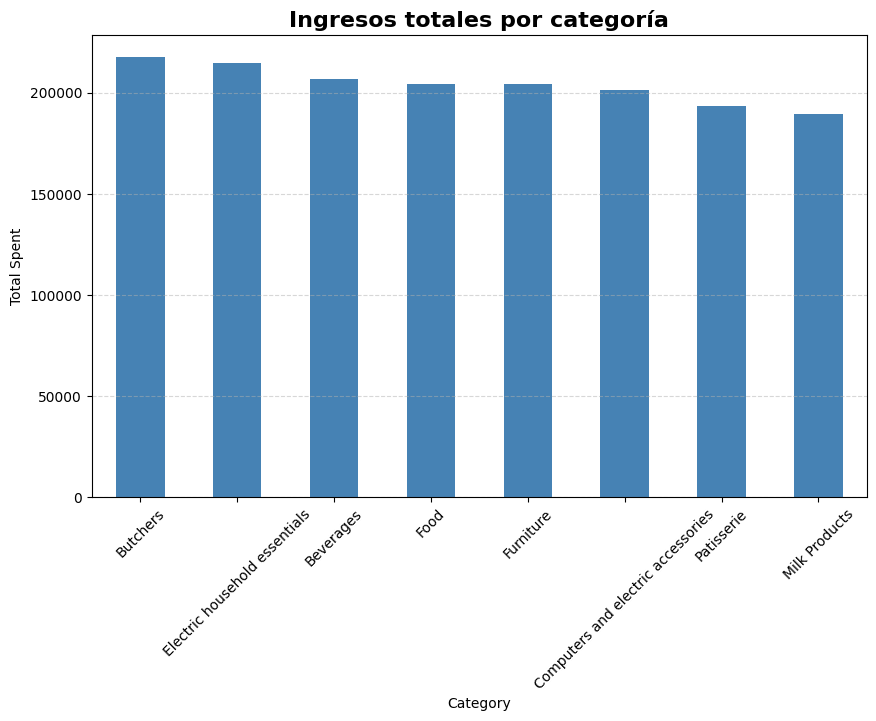

In [ ]:
import matplotlib.pyplot as plt

category_sales = (
    clean_df
    .groupby("category")["total_spent"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
category_sales.plot(kind="bar", color="steelblue")

plt.title("Ingresos totales por categoría", fontsize=16, fontweight="bold")
plt.xlabel("Category")
plt.ylabel("Total Spent")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

Este gráfico muestra la clasificación directa de las categorías por facturación total. Observamos que las categorías de mayor rendimiento son “Butchers”, “Electric household essentials” y “Beverages”. Las categorías con menor facturación son “Milk Products” y “Patisserie”. La diferencia entre las categorías es relativamente moderada, lo que indica ninguna categoría es dominante en exceso y que el negocio está diversificado en términos de ingresos.

Esta visualización es útil para identificar de un vistazo qué líneas de productos son más rentables.

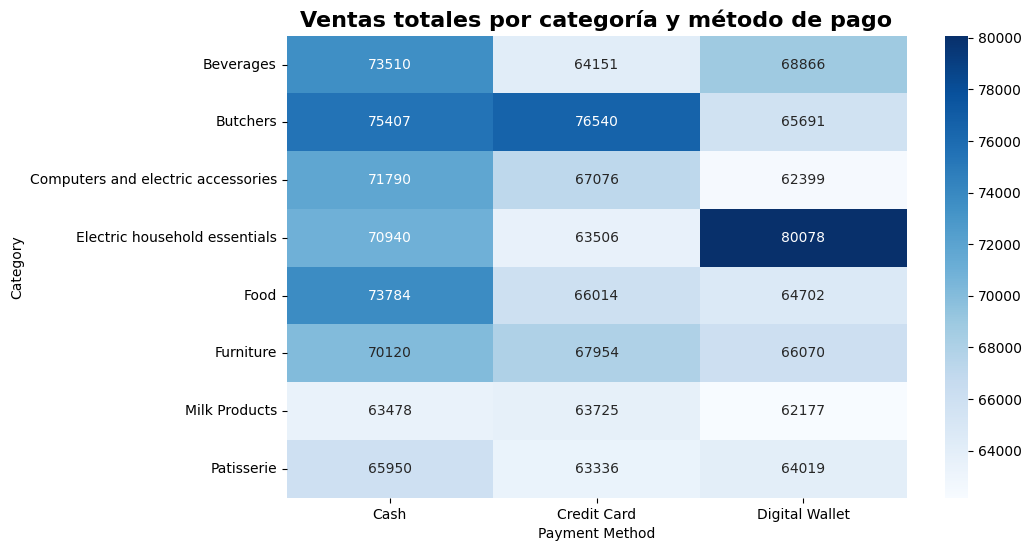

In [ ]:
import seaborn as sns

pivot_table = (
    clean_df
    .pivot_table(
        index="category",
        columns="payment_method",
        values="total_spent",
        aggfunc="sum"
    )
)

plt.figure(figsize=(10,6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".0f",
    cmap="Blues"
)

plt.title("Ventas totales por categoría y método de pago", fontsize=16, fontweight="bold")
plt.xlabel("Payment Method")
plt.ylabel("Category")
plt.show()

Este gráfico muestra cómo se distribuyen los ingresos totales según cada combinación de categoría de producto y método de pago. Se observa que:

Las categorías con mayores ingresos son “Butchers” y “Electric household essentials”, que presentan colores más oscuros.

El pago con “Digital Wallet” es especialmente alto en “Electric household essentials”, lo que sugiere una buena adopción de pagos electrónicos en este tipo de compras, mientras que el pago con "Credit Card" y "Cash" destaca en Butchers.

En general, no se aprecian diferencias excesivamente grandes entre los métodos de pago dentro de una misma categoría, lo que indica que el cliente utiliza diversos sistemas de cobro sin grandes variaciones de comportamiento.

Este gráfico es útil para comprender qué segmento del negocio genera más ingresos y si los métodos de pago están asociados a distintas líneas de productos.

<Figure size 1000x500 with 0 Axes>

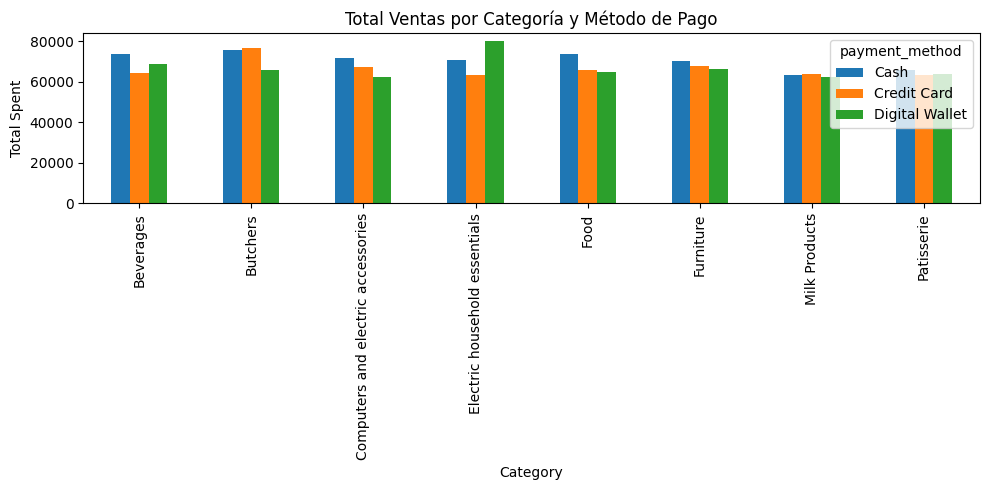

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ventas por categoría y método de pago
pivot = clean_df.pivot_table(values='total_spent', index='category', columns='payment_method', aggfunc='sum')
plt.figure()
pivot.plot(kind='bar')
plt.title('Total Ventas por Categoría y Método de Pago')
plt.xlabel('Category')
plt.ylabel('Total Spent')
plt.tight_layout()
plt.show()

Este gráfico refuerza el gráfico anterior, pero con una visualización más clara. Se confirman las mismas categorías líderes en ventas, con “Butchers”, “Electric household essentials” y “Beverages” destacando sobre el resto.

La distribución de los métodos es bastante uniforme dentro de cada categoría, lo que indica que los clientes emplean distintos métodos sin diferencias marcadas según el tipo de producto.

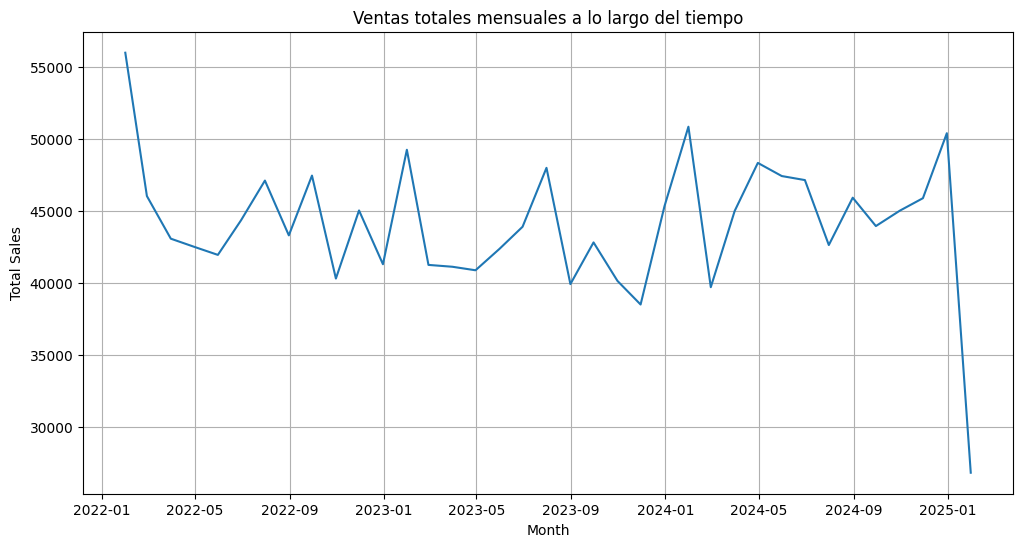

In [ ]:
clean_df["transaction_date"] = pd.to_datetime(clean_df["transaction_date"])

monthly_sales = (
    clean_df
    .set_index("transaction_date")
    .resample("ME")["total_spent"]
    .sum()
)

plt.figure(figsize=(12,6))
plt.plot(monthly_sales)
plt.title("Ventas totales mensuales a lo largo del tiempo")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


El gráfico muestra la evolución mes a mes de las ventas totales durante el periodo de estudio. Las conclusiones principales son que las ventas presentan variaciones periódicas, con picos y descensos a lo largo del tiempo, aunque sin una estacionalidad clara. No se detecta una tendencia fuerte al alza o a la baja; las ventas se mantienen relativamente estables durante la mayor parte del periodo.

En el tramo final se aprecia una caída pronunciada, lo que podría deberse a que no hay datos más allá de 2025-01.

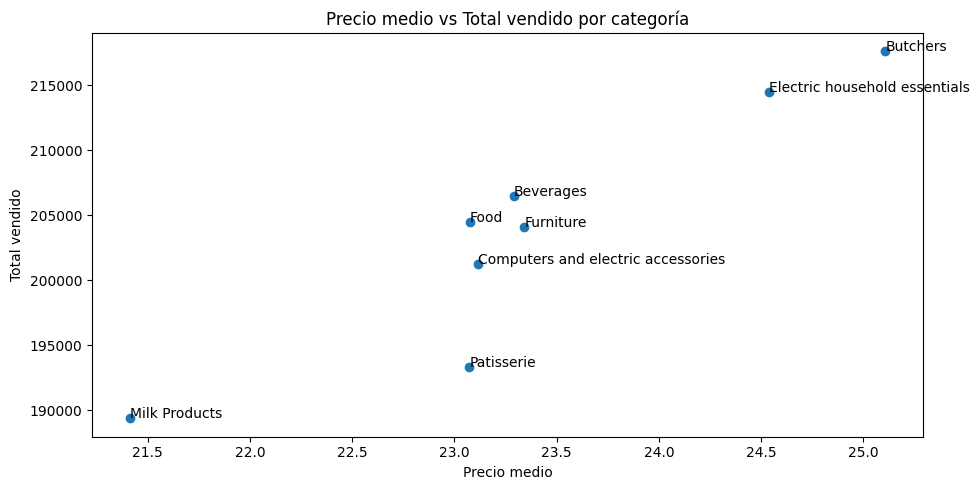

In [ ]:
# Relación precio medio por unidad vs total vendido por categoría
cat_stats = clean_df.groupby('category').agg({'price_per_unit':'mean','total_spent':'sum'})
plt.figure()
plt.scatter(cat_stats['price_per_unit'], cat_stats['total_spent'])
for i in cat_stats.index:
    plt.text(cat_stats.loc[i,'price_per_unit'], cat_stats.loc[i,'total_spent'], i)
plt.title('Precio medio vs Total vendido por categoría')
plt.xlabel('Precio medio')
plt.ylabel('Total vendido')
plt.tight_layout()
plt.show()

Este gráfico muestra la relación entre el precio promedio de los productos de cada categoría y el total vendido en esa misma categoría. La lectura es especialmente interesante porque combina dos dimensiones clave: precio y volumen de ventas.

Observamos que Butchers es claramente la categoría más destacada, tiene el precio medio más alto (aprox. 25). Y también el mayor total vendido (supera los 215.000). Esto indica que es una categoría premium y muy rentable, donde los clientes están dispuestos a pagar más.

Electric household essentials ocupa un segundo lugar muy fuerte, con un precio alto y un volumen de ventas también alto. Se trataría pues de otra categoría “estrella”: productos de precio elevado pero con fuerte rotación.

En el rango de precios medios (23–23.5), categorías como Beverages, Furniture, Food o Computers and electric accessories presentan volúmenes de venta similares. Esto indica un grupo estable, donde los precios intermedios generan ventas sólidas pero sin llegar al liderazgo de las categorías premium.

Patisserie aparece ligeramente por debajo en total vendido para su rango de precios. Podría ser una categoría con potencial, pero actualmente no destaca ni por precio ni por volumen.

Milk Products presenta el precio medio más bajo (aprox. 21.5) con el volumen de ventas más bajo del gráfico.

En resumen, el gráfico sugiere una estructura de negocio donde las categorías más caras son las que más venden, lo cual no siempre es común en retail. Esto indica que hay clientes dispuestos a gastar más en ciertos tipos de productos (carne y electrodomésticos) y por otro lado, una oportunidad para revisar la estrategia de categorías con precios medios pero menores ventas (Patisserie, Milk Products).

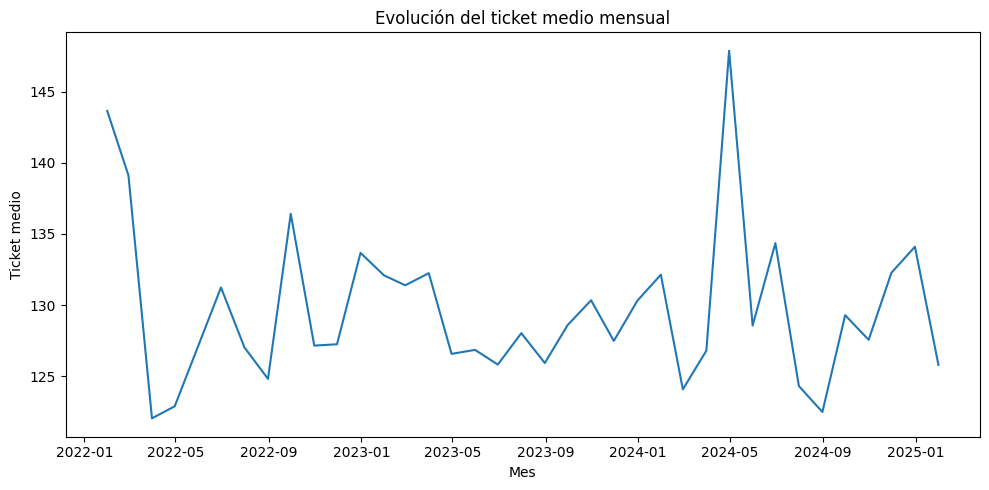

In [ ]:
# Distribución mensual del ticket medio
clean_df['ticket'] = clean_df['total_spent']
monthly_ticket = clean_df.groupby(pd.Grouper(key='transaction_date', freq='ME'))['ticket'].mean()
plt.figure()
plt.plot(monthly_ticket.index, monthly_ticket.values)
plt.title('Evolución del ticket medio mensual')
plt.xlabel('Mes')
plt.ylabel('Ticket medio')
plt.tight_layout()
plt.show()

Este gráfico analiza cómo ha evolucionado el gasto promedio por transacción desde 2022 hasta principios de 2025.

En resumen observamos que, en el inicio de 2022 el ticket medio es muy alto (aprox. 140–143). Podría deberse a compras estacionales (año nuevo, rebajas, etc.) o a un mix de productos más caros en ese periodo.

Por otra parte, se nota un descenso notable a lo largo de 2022, con variaciones mensuales entre 122 y 135. Parece una estabilización después de un pico inicial.

Durante 2023, el ticket medio se mantiene bastante estable, oscilando entre 127 y 133. Indica un comportamiento de cliente predecible y sin cambios estructurales en precios o mix.

En 2024 aparece un pico extraordinario en abril/mayo, donde el ticket sube hasta casi 150, el valor más alto de todo el periodo. Esto podría estar relacionado con un evento promocional, una campaña de venta de productos premium, cambios estacionales (Semana Santa, por ejemplo) o un aumento de precios temporal. El salto es muy atípico y se debería investigar.

Tras ese pico, el ticket vuelve a descender a valores entre 125 y 135, y se mantiene estable durante el resto del año, sin tendencia clara al alza o a la baja.

En resumen, la evolución del ticket medio muestra estabilidad general del gasto por transacción a lo largo de los años, un ciclo de compra relativamente estable, sin grandes cambios estructurales y un pico anómalo en 2024 que merece análisis específico.


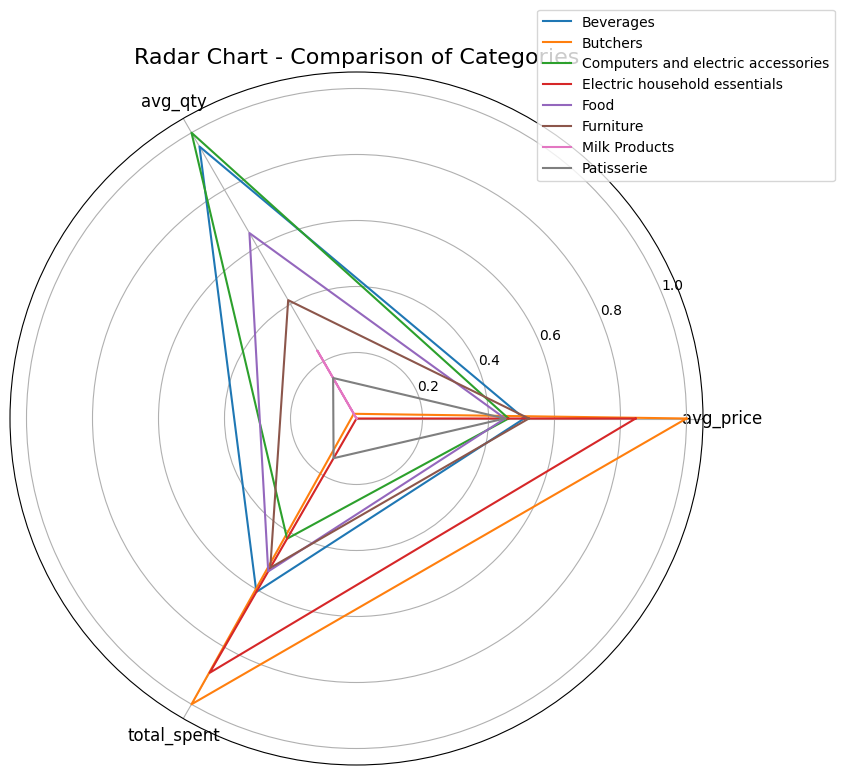

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Agrupar métricas por categoría
metrics = clean_df.groupby("category").agg(
    avg_price=("price_per_unit", "mean"),
    avg_qty=("quantity", "mean"),
    total_spent=("total_spent", "sum")
)

# Normalizar para que todas las variables estén en misma escala
metrics_norm = (metrics - metrics.min()) / (metrics.max() - metrics.min())

labels = metrics_norm.index.tolist()
stats = metrics_norm.values

# Ángulos para el radar
num_vars = stats.shape[1]
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(9, 9))

# Dibujar una línea por cada categoría
for i, row in enumerate(stats):
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, linewidth=1.5, linestyle='solid', label=labels[i])

plt.xticks(angles[:-1], metrics_norm.columns, fontsize=12)
plt.title("Radar Chart - Comparison of Categories", fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


El radar chart permite comparar visualmente el rendimiento de cada categoría del comercio en tres dimensiones clave: precio medio por unidad (avg_price), cantidad media comprada (avg_qty) y gasto total asociado (total_spent). Gracias a la normalización aplicada, los valores están representados en una escala común entre 0 y 1, lo que facilita la comparación.

En primer lugar, se observa que “Butchers” destaca claramente por encima del resto en el precio medio por unidad, posicionándose como la categoría con mayor valor relativo y también como una de las que generan mayor gasto total. Esto indica que es un segmento con transacciones de importe alto, probablemente asociado a productos de mayor calidad o mayor coste por unidad.

Por otro lado, “Computers and electric accessories” y “Electric household essentials” muestran los valores más elevados en la cantidad media comprada, lo que sugiere que los clientes suelen adquirir un mayor número de unidades por transacción, aunque sin estar necesariamente asociadas a un precio unitario elevado. Esto puede responder a compras de productos más pequeños o accesorios en mayor volumen.

En cuanto al gasto total (total_spent), además de “Butchers”, también “Electric household essentials” y “Food” presentan buenos resultados, lo que revela que son categorías de alta rotación y con buen rendimiento económico global para el negocio.

Finalmente, algunas categorías, como “Milk Products” o “Patisserie”, quedan rezagadas en las tres variables, indicando menor contribución global tanto en ticket medio como en número de unidades vendidas.

En conjunto, el radar chart hace evidente que el rendimiento de las categorías del comercio es heterogéneo, con segmentos que destacan por precio, otros por cantidad y algunos por volumen total de ventas. Este tipo de representación visual facilita identificar rápidamente qué áreas son más fuertes y dónde podrían existir oportunidades de crecimiento o mejora.

##7. Conclusiones

El análisis exploratorio que hemos realizado sobre el dataset de ventas retail nos ha permitido comprender de manera clara la estructura, el dominio y las características fundamentales de la información disponible. En una primera revisión vimos que teníamos datos completos en la mayoría de columnas clave, aunque existían valores nulos en unas pocas columnas. Estos problemas no solo hacían evidente la necesidad de limpieza, sino que también nos ofrecían una primera visión sobre la calidad inicial del dataset, que aunque útil y bien estructurado, requería un tratamiento cuidadoso para asegurar la consistencia analítica.

El proceso de limpieza lo hemos desarrollado de forma sistemática, documentada y justificada. Hemos imputado valores faltantes en Item asignando identificadores consistentes con la categoría del producto; en Price Per Unit y Quantity utilizando información real del propio registro cuando era posible, o aplicando medidas estadísticas como la media agrupada por artículo; mientras que Total Spent lo hemos recalculado directamente a partir del producto de las dos anteriores una vez estaban completas. Asimismo, hemos estandarizado los nombres de variables y verificado la ausencia final de nulos. Como resultado, el dataset final es más sólido, coherente y preparado para un análisis posterior o un modelo predictivo.

El estudio descriptivo posterior nos ha permitido extraer hallazgos valiosos. Entre ellos, detectamos que ciertas categorías concentran el mayor volumen económico de ventas, que los clientes tienden a realizar compras de importes moderados, y que la distribución de Total Spent presenta una cola positiva debido a compras de alto valor. La matriz de correlaciones mostró relaciones lógicas entre las variables numéricas, como la fuerte asociación lineal entre Quantity y Total Spent. Además, el análisis de métodos de pago, descuentos y comportamiento por ubicación o categoría ha revelado patrones de consumo útiles para tomar decisiones comerciales.

En resumen, el trabajo lo hemos desarrollado de forma ordenada y transparente, mostrando un proceso completo de inspección, limpieza, validación y visualización, documentado paso a paso. El dataset ha pasado de un estado con inconsistencias a una versión limpia, analítica y lista para ser utilizada en fases posteriores de modelización o toma de decisiones. El resultado es un análisis exploratorio claro, reproducible y con conclusiones relevantes para la comprensión del negocio y la gestión del producto.